In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Final_Task/loan_data_2007_2014.csv')

<ipython-input-2-b6cbd8d733a9>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/Final_Task/loan_data_2007_2014.csv')


In [3]:
# Data Understanding
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [4]:
data.shape

(466285, 75)

In [5]:
cols_to_drop = [
    'id', 'member_id', 'url', 'desc', 'zip_code' , 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'sub_grade'
]

In [6]:
data = data.drop(cols_to_drop, axis=1)

In [7]:
col=['Unnamed: 0']
data = data.drop(col, axis=1)

In [8]:
data.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,NaN,10+ years,RENT,...,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,Ryder,< 1 year,RENT,...,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,NaN,10+ years,RENT,...,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,AIR RESOURCES BOARD,10+ years,RENT,...,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,University Medical Group,1 year,RENT,...,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN


In [9]:
data.loan_status.value_counts(normalize=True)*100

loan_status
Current                                                48.087757
Fully Paid                                             39.619332
Charged Off                                             9.109236
Late (31-120 days)                                      1.479782
In Grace Period                                         0.674695
Does not meet the credit policy. Status:Fully Paid      0.426349
Late (16-30 days)                                       0.261214
Default                                                 0.178432
Does not meet the credit policy. Status:Charged Off     0.163205
Name: proportion, dtype: float64

In [10]:
bad_status = ['Charged Off' , 'Default' , 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)'
]

data['bad_flag'] = np.where(data['loan_status'].isin(bad_status), 1, 0)

In [11]:
data['bad_flag'].value_counts(normalize=True)*100

bad_flag
0    89.069346
1    10.930654
Name: proportion, dtype: float64

In [12]:
data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [13]:
data['emp_length_int'] = data['emp_length'].str.replace('\+ years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace('< 1 year', str(0))
data['emp_length_int'] = data['emp_length_int'].str.replace(' years', '')
data['emp_length_int'] = data['emp_length_int'].str.replace(' year', '')

In [14]:
data['emp_length_int'] = data['emp_length_int'].replace({'10+': 10})

In [15]:
data['emp_length_int'] = data['emp_length_int'].astype(float)

In [16]:
data.drop('emp_length', axis=1, inplace=True)

In [17]:
data['term'].unique()
data['term_int'] = data['term'].str.replace(' months', '')
data['term_int'] = data['term_int'].astype(float)
data.drop('term', axis=1, inplace=True)

In [18]:
data['earliest_cr_line'].head(3)
data['earliest_cr_line_date'] = pd.to_datetime(data['earliest_cr_line'], format='%b-%y')
data['earliest_cr_line_date'].head(3)
data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))
data['mths_since_earliest_cr_line'].head(3)
data['mths_since_earliest_cr_line'].describe()
data[data['mths_since_earliest_cr_line']<0][['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']].head(3)

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-527.0
1770,Sep-68,2068-09-01,-598.0
2799,Sep-64,2064-09-01,-551.0


In [19]:
data.loc[data['mths_since_earliest_cr_line']<0, 'mths_since_earliest_cr_line'] = data['mths_since_earliest_cr_line'].max()
data.drop(['earliest_cr_line', 'earliest_cr_line_date'], axis=1, inplace=True)

In [20]:
data['issue_d_date'] = pd.to_datetime(data['issue_d'], format='%b-%y')
data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['issue_d_date']) / np.timedelta64(1, 'M')))
data['mths_since_issue_d'].describe()
data.drop(['issue_d', 'issue_d_date'], axis=1, inplace=True)

In [21]:
data['last_pymnt_d_date'] = pd.to_datetime(data['last_pymnt_d'], format='%b-%y')
data['mths_since_last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['last_pymnt_d_date']) / np.timedelta64(1, 'M')))
data['mths_since_last_pymnt_d'].describe()
data.drop(['last_pymnt_d', 'last_pymnt_d_date'], axis=1, inplace=True)

In [22]:
data['next_pymnt_d_date'] = pd.to_datetime(data['next_pymnt_d'], format='%b-%y')
data['mths_since_next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['next_pymnt_d_date']) / np.timedelta64(1, 'M')))
data['mths_since_next_pymnt_d'].describe()
data.drop(['next_pymnt_d', 'next_pymnt_d_date'], axis=1, inplace=True)

In [23]:
data['last_credit_pull_d_date'] = pd.to_datetime(data['last_credit_pull_d'], format='%b-%y')
data['mths_since_last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - data['last_credit_pull_d_date']) / np.timedelta64(1, 'M')))
data['mths_since_last_credit_pull_d'].describe()
data.drop(['last_credit_pull_d', 'last_credit_pull_d_date'], axis=1, inplace=True)

Column grade unique values: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
Column emp_title unique values: [nan 'Ryder' 'AIR RESOURCES BOARD' ... 'MecÃ¡nica'
 'Chief of Interpretation (Park Ranger)' 'Server Engineer Lead']
Column home_ownership unique values: ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
Column verification_status unique values: ['Verified' 'Source Verified' 'Not Verified']
Column loan_status unique values: ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']
Column pymnt_plan unique values: ['n' 'y']
Column purpose unique values: ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
Column title unique values: ['Computer' 'bike' 'real estate business' ... 'LoanGetter'
 'Consolidation 01' 'Pa

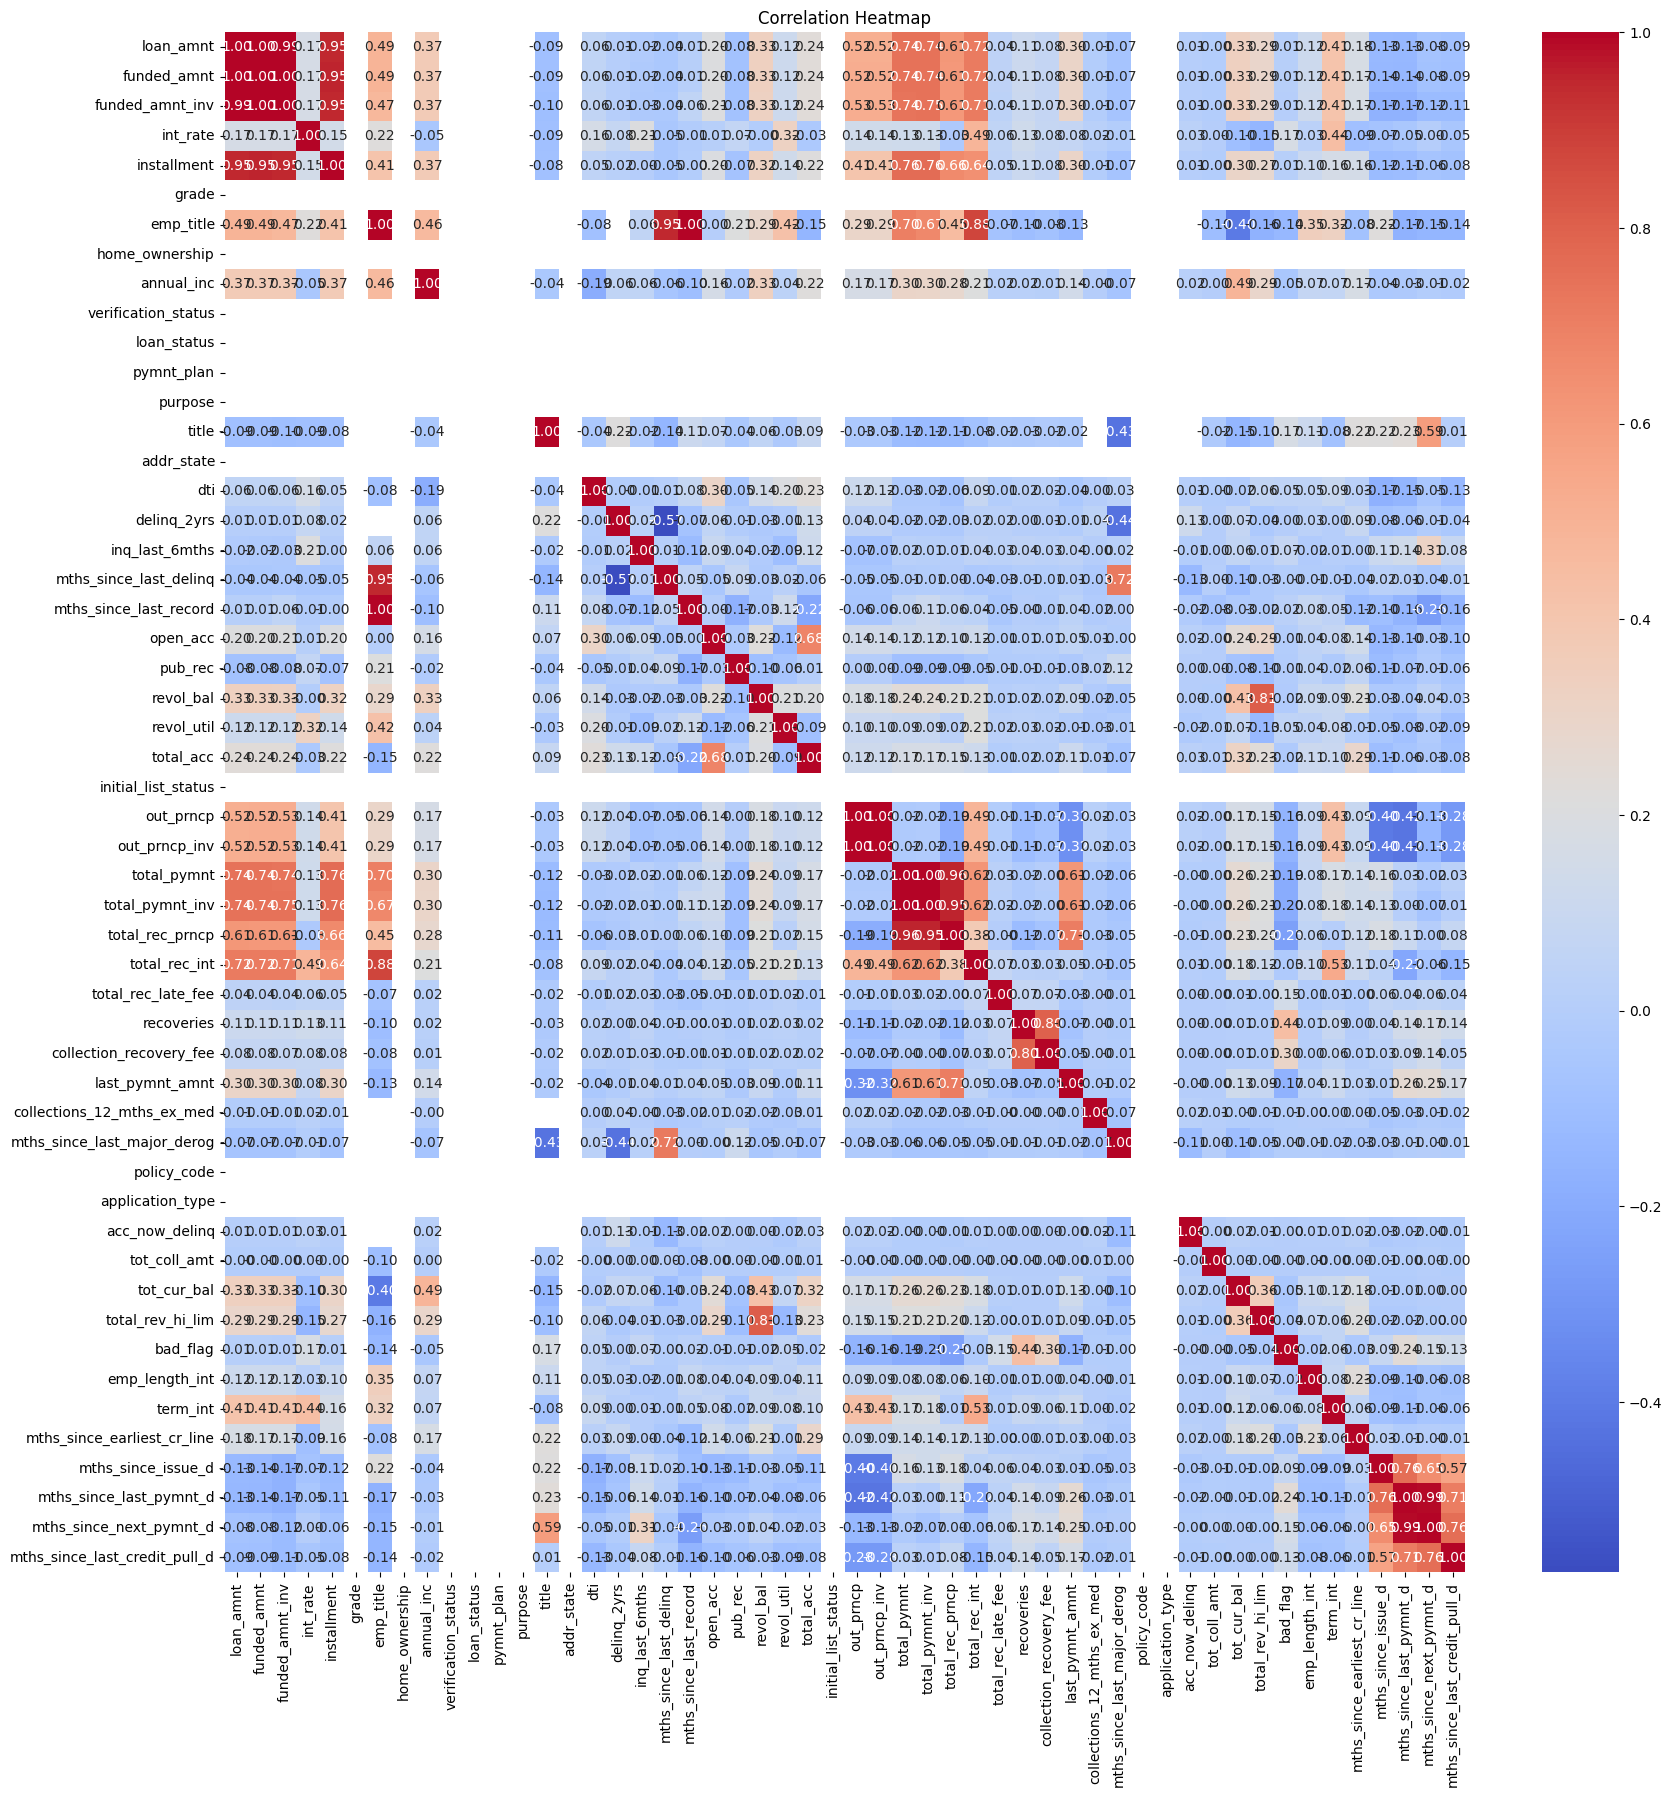

In [28]:
# Identify columns with non-numeric values
for column in data.columns:
    if data[column].dtype == 'object':
        print(f"Column {column} unique values: {data[column].unique()}")

# Convert non-numeric columns to numeric or handle them appropriately
data = data.apply(pd.to_numeric, errors='coerce')

# Now try plotting the heatmap again
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [30]:
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))
to_drop_hicorr = [column for column in upper.columns if any(upper[column] > 0.7)]

In [31]:
to_drop_hicorr

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'mths_since_last_major_derog',
 'total_rev_hi_lim',
 'mths_since_last_pymnt_d',
 'mths_since_next_pymnt_d',
 'mths_since_last_credit_pull_d']

In [32]:
data.drop(to_drop_hicorr, axis=1, inplace=True)

In [33]:
data.drop(['emp_title', 'title', 'application_type'], axis=1, inplace=True)

In [34]:
data.drop(['policy_code'], axis=1, inplace=True)
for col in data.select_dtypes(include='object').columns.tolist():
    print(data[col].value_counts(normalize=True)*100)
    print('\n')

data.drop('pymnt_plan', axis=1, inplace=True)

In [35]:
check_missing = data.isnull().sum() * 100 / data.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

grade                          100.000000
initial_list_status            100.000000
verification_status            100.000000
loan_status                    100.000000
purpose                        100.000000
addr_state                     100.000000
home_ownership                 100.000000
tot_cur_bal                     15.071469
tot_coll_amt                    15.071469
emp_length_int                   4.505399
revol_util                       0.072917
collections_12_mths_ex_med       0.031097
acc_now_delinq                   0.006219
pub_rec                          0.006219
total_acc                        0.006219
open_acc                         0.006219
inq_last_6mths                   0.006219
delinq_2yrs                      0.006219
mths_since_earliest_cr_line      0.006219
annual_inc                       0.000858
dtype: float64

In [36]:
data['annual_inc'].fillna(data['annual_inc'].mean(), inplace=True)
data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
data['acc_now_delinq'].fillna(0, inplace=True)
data['total_acc'].fillna(0, inplace=True)
data['pub_rec'].fillna(0, inplace=True)
data['open_acc'].fillna(0, inplace=True)
data['inq_last_6mths'].fillna(0, inplace=True)
data['delinq_2yrs'].fillna(0, inplace=True)
data['collections_12_mths_ex_med'].fillna(0, inplace=True)
data['revol_util'].fillna(0, inplace=True)
data['emp_length_int'].fillna(0, inplace=True)
data['tot_cur_bal'].fillna(0, inplace=True)
data['tot_coll_amt'].fillna(0, inplace=True)

In [37]:
# Identify categorical columns
categorical_cols = data.select_dtypes(include='object').columns.tolist()

# Check if there are any categorical columns
if len(categorical_cols) == 0:
    print("No categorical columns found.")
else:
    # Generate one-hot encoded DataFrame
    onehot = pd.get_dummies(data[categorical_cols], drop_first=True)
    onehot.head()

No categorical columns found.


In [40]:
numerical_cols = [col for col in data.columns.tolist() if col not in categorical_cols + ['bad_flag']]

ss = StandardScaler()
std = pd.DataFrame(ss.fit_transform(data[numerical_cols]), columns=numerical_cols)
std.head()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,loan_amnt,int_rate,grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,...,total_rec_late_fee,recoveries,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,emp_length_int,term_int,mths_since_earliest_cr_line,mths_since_issue_d
0,-1.124392,-0.729587,NaN,NaN,-0.896551,NaN,NaN,NaN,NaN,1.328632,...,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,1.766910,1.465462
1,-1.426088,0.330634,NaN,NaN,-0.787387,NaN,NaN,NaN,NaN,-2.065791,...,-0.123464,0.057470,-0.083608,-0.058307,-0.012089,-0.792648,-1.523744,1.622784,-0.211720,1.465462
2,-1.438156,0.488979,NaN,NaN,-1.110294,NaN,NaN,NaN,NaN,-1.082491,...,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,-0.576824,1.465462
3,-0.521001,-0.077850,NaN,NaN,-0.438063,NaN,NaN,NaN,NaN,0.354248,...,3.099264,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,1.138605,-0.616225,0.224050,1.465462
4,-1.365749,-0.261438,NaN,NaN,0.122311,NaN,NaN,NaN,NaN,0.091865,...,-0.123464,-0.154549,-0.083608,-0.058307,-0.012089,-0.792648,-1.257509,1.622784,0.235828,1.465462


In [41]:
data_model = pd.concat([ std, data[['bad_flag']]], axis=1)

In [42]:
from sklearn.model_selection import train_test_split
X = data_model.drop('bad_flag', axis=1)
y = data_model['bad_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((373028, 29), (93257, 29))

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
missing_values = X_train.columns[X_train.isnull().any()]
print(missing_values)

Index(['grade', 'home_ownership', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'initial_list_status'],
      dtype='object')


In [45]:
from sklearn.impute import SimpleImputer

# Create an imputer object with strategy 'mean'
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on X_train
X_train_imputed = imputer.fit_transform(X_train)

# Now, X_train_imputed should not contain any NaN values

In [50]:
arr_feature_importances = rfc.feature_importances_
arr_feature_names = X_train.columns.values

In [51]:
# Check the length of df_feature_importance's index
print(len(df_feature_importance))

# Ensure arr_feature_names matches the length of df_feature_importance
if len(arr_feature_names) == len(df_feature_importance):
    df_feature_importance['feature'] = arr_feature_names
    df_feature_importance['importance'] = arr_feature_importances
    df_all_features = df_feature_importance.sort_values(by='importance', ascending=False)
else:
    print("Lengths of arr_feature_names and df_feature_importance do not match.")

22
Lengths of arr_feature_names and df_feature_importance do not match.


In [52]:
# Assuming imputer is already defined from previous steps
X_test_imputed = imputer.transform(X_test)

In [53]:
y_pred_proba = rfc.predict_proba(X_test_imputed)[:, 1]

In [54]:
df_actual_predicted = pd.concat([
    pd.DataFrame(np.array(y_test), columns=['y_actual']),
    pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])
], axis=1)

df_actual_predicted.index = y_test.index

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create Logistic Regression model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train_imputed, y_train)

LogisticRegression()

In [64]:
# Predict on test set
y_pred_log_reg = log_reg.predict(X_test_imputed)

In [65]:
# Calculate evaluation metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

In [66]:
# Print evaluation metrics
print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1-score: {f1_log_reg:.4f}")

Logistic Regression Model Evaluation:
Accuracy: 0.9397
Precision: 0.9808
Recall: 0.4569
F1-score: 0.6234


In [67]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for Logistic Regression
y_pred_proba_log_reg = log_reg.predict_proba(X_test_imputed)[:, 1]

# Compute ROC AUC score
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)

# Print ROC AUC score
print(f"ROC AUC Score (Logistic Regression): {roc_auc_log_reg:.4f}")

# Compute ROC curve
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)

ROC AUC Score (Logistic Regression): 0.8538


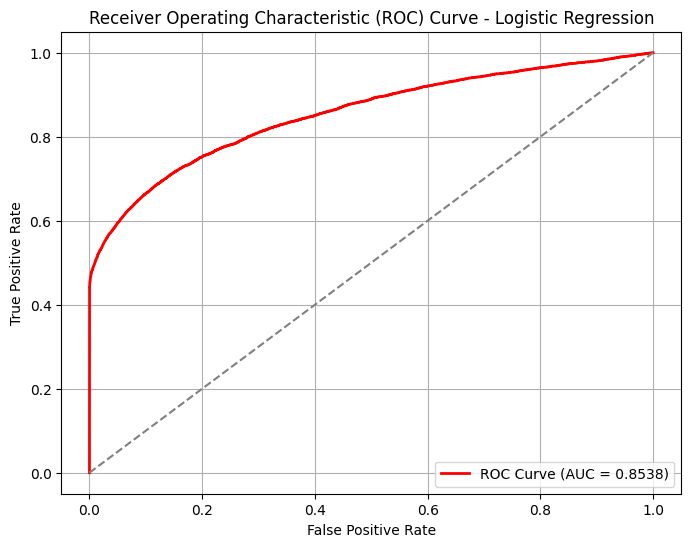

In [69]:
# Plot ROC curve for Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='red', lw=2, label=f'ROC Curve (AUC = {roc_auc_log_reg:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=4)
rfc.fit(X_train_imputed, y_train)

RandomForestClassifier(max_depth=4)

In [57]:
# Predict probabilities on test set
y_pred_proba_rfc = rfc.predict_proba(X_test_imputed)[:, 1]

# Predict classes on test set
y_pred_rfc = rfc.predict(X_test_imputed)

In [60]:
# Calculate evaluation metrics
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc)

# Print evaluation metrics
print("\nRandom Forest Classifier Model Evaluation:")
print(f"Accuracy: {accuracy_rfc:.4f}")
print(f"Precision: {precision_rfc:.4f}")
print(f"Recall: {recall_rfc:.4f}")
print(f"F1-score: {f1_rfc:.4f}")


Random Forest Classifier Model Evaluation:
Accuracy: 0.9429
Precision: 1.0000
Recall: 0.4776
F1-score: 0.6465


In [61]:
# Predict probabilities for Random Forest Classifier (already predicted above)
# y_pred_proba_rfc = rfc.predict_proba(X_test_imputed)[:, 1]

# Compute ROC AUC score
roc_auc_rfc = roc_auc_score(y_test, y_pred_proba_rfc)

# Print ROC AUC score
print(f"ROC AUC Score (Random Forest Classifier): {roc_auc_rfc:.4f}")

# Compute ROC curve
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_proba_rfc)

ROC AUC Score (Random Forest Classifier): 0.8646


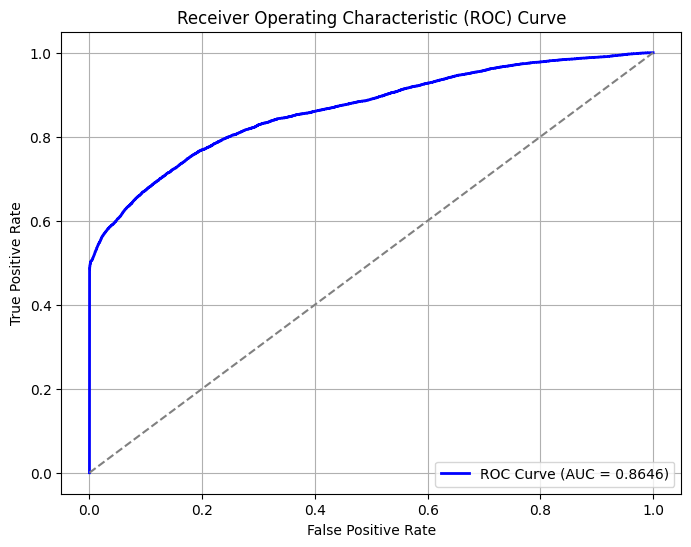

In [62]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_rfc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()